In [1]:
import os

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import image
import seaborn as sns

from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" # Block Numa warning

In [3]:
input_folder = "/kaggle/input/"
dataset_folder = input_folder + "eurosat-dataset/" + "EuroSAT/"

In [4]:
column_names =  ["id", "path", "class_id", "class_name"]

training_df = pd.read_csv(dataset_folder + "train.csv", names=column_names)
validation_df = pd.read_csv(dataset_folder + "validation.csv", names=column_names)
test_df = pd.read_csv(dataset_folder + "test.csv", names=column_names)

In [5]:
training_df_size = len(training_df)
validation_df_size = len(validation_df)
test_df_size = len(test_df)

total_dataset_size = training_df_size + validation_df_size + test_df_size

print(f"Training set size: {training_df_size} ({round(training_df_size / total_dataset_size * 100)}%)")
print(f"Validation set size: {validation_df_size} ({round(validation_df_size / total_dataset_size * 100)}%)")
print(f"Test set size: {test_df_size} ({round(test_df_size / total_dataset_size * 100)}%)")

Training set size: 18901 (70%)
Validation set size: 5401 (20%)
Test set size: 2701 (10%)


In [6]:
rescaling_factor = 1. / 255

In [7]:
training_generator = ImageDataGenerator(rescale=rescaling_factor)
test_generator = ImageDataGenerator(rescale=rescaling_factor)

In [8]:
image_width = 64
image_height = 64

In [9]:
batch_size = 128

In [10]:
training_set = training_generator.flow_from_dataframe(
    dataframe=training_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle="true",
)

validation_set = test_generator.flow_from_dataframe(
    dataframe=validation_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle="true",
)

test_set = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 18900 validated image filenames belonging to 10 classes.
Found 5400 validated image filenames belonging to 10 classes.
Found 2700 validated image filenames belonging to 10 classes.


In [11]:
class_name_list = np.array(list(training_set.class_indices.keys()))
labels, count = np.unique(training_set.classes, return_counts=True)

print(pd.Series(count, index=class_name_list))

AnnualCrop              2100
Forest                  2100
HerbaceousVegetation    2100
Highway                 1750
Industrial              1750
Pasture                 1400
PermanentCrop           1750
Residential             2100
River                   1750
SeaLake                 2100
dtype: int64


In [12]:
figure_height = 3
figure_width = 3
figure_size = (14, 14)

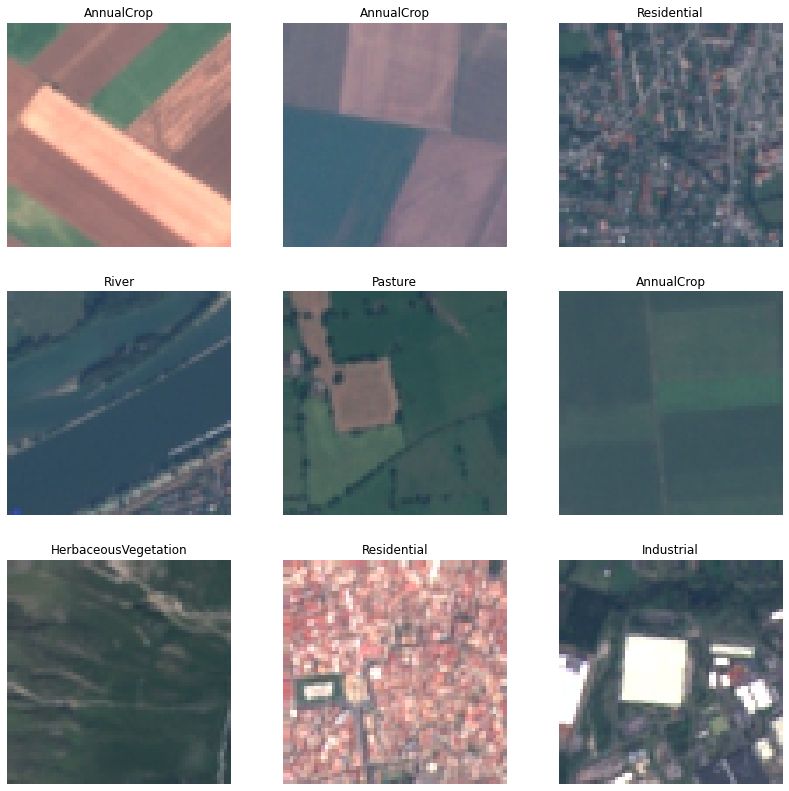

In [13]:
images, class_ids = next(training_set)
plt.figure(figsize=figure_size)
for index in range(figure_height * figure_width):
    plt.subplot(figure_height, figure_width, index + 1)
    plt.imshow(images[index])
    plt.title(class_name_list[class_ids[index].astype(bool)][0])
    plt.axis("off")

## Load VGG16 architecture

In [14]:
base_model = VGG16(include_top=False, input_shape=(64, 64, 3))
base_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
______________________________________________________________

In [15]:
class_count = len(class_name_list)
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units=512, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(class_count, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 15,768,906
Trainable params: 15,768,906
Non-trainable params: 0
_________________________________________________________________


In [16]:
model_path = "/kaggle/working/models/eurosat_rgb_model.h5"

checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5) 
early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=True)

callback_list = [checkpoint, early_stopping, reduce_lr]

In [17]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"])

In [18]:
history = model.fit(
    training_set,
    validation_data=validation_set,
    callbacks=callback_list,
    epochs=100,
    verbose=1,
)

Epoch 1/100
148/148 [==============================] - 122s 763ms/step - loss: 0.6699 - accuracy: 0.7669 - val_loss: 0.2496 - val_accuracy: 0.9189
Epoch 2/100
148/148 [==============================] - 20s 138ms/step - loss: 0.2083 - accuracy: 0.9319 - val_loss: 0.1860 - val_accuracy: 0.9396
Epoch 3/100
148/148 [==============================] - 22s 147ms/step - loss: 0.1457 - accuracy: 0.9530 - val_loss: 0.1469 - val_accuracy: 0.9580
Epoch 4/100
148/148 [==============================] - 21s 144ms/step - loss: 0.1153 - accuracy: 0.9613 - val_loss: 0.1429 - val_accuracy: 0.9583
Epoch 5/100
148/148 [==============================] - 22s 147ms/step - loss: 0.0873 - accuracy: 0.9722 - val_loss: 0.1488 - val_accuracy: 0.9557
Epoch 6/100
148/148 [==============================] - 22s 149ms/step - loss: 0.0882 - accuracy: 0.9717 - val_loss: 0.1655 - val_accuracy: 0.9569
Epoch 7/100
148/148 [==============================] - 21s 144ms/step - loss: 0.0871 - accuracy: 0.9715 - val_loss: 0.1725 

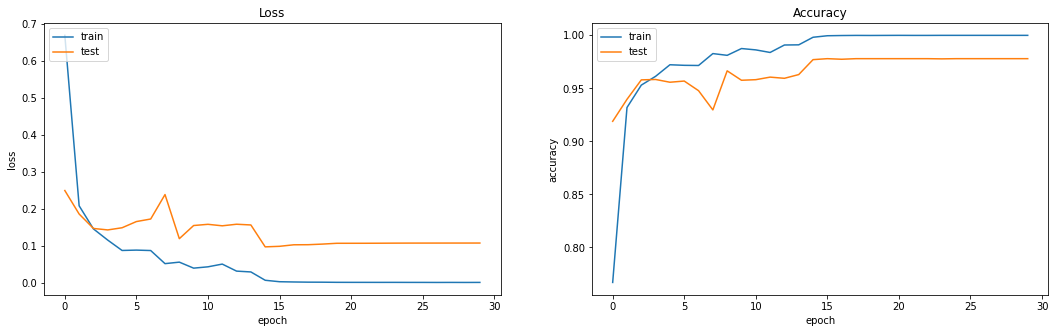

In [19]:
plt.figure(figsize=(18, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")

plt.show()

In [20]:
loss, accuracy = model.evaluate(test_set, verbose=1)

22/22 [==============================] - 15s 714ms/step - loss: 0.0727 - accuracy: 0.9815


In [21]:
test_set.reset()

In [22]:
predicted_probabilities = model.predict(test_set, steps=test_set.n, verbose=1)
predicted_class_ids = np.argmax(predicted_probabilities, axis=1)

2700/2700 [==============================] - 3s 842us/step


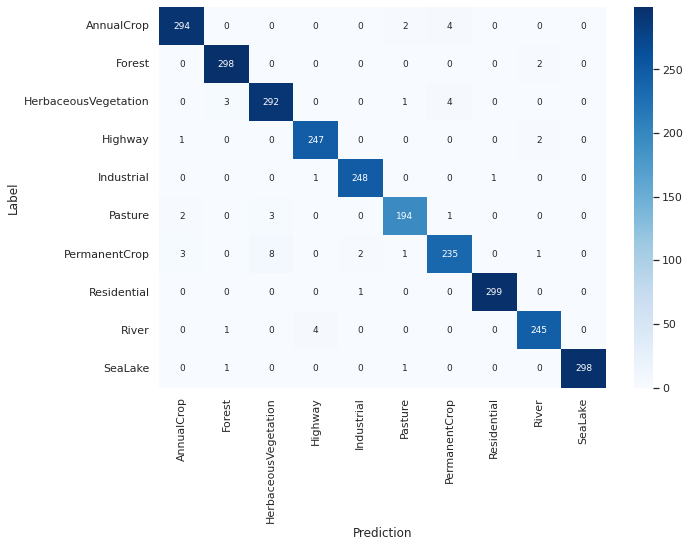

In [23]:
confusion_matrix_array = confusion_matrix(y_true=test_set.labels, y_pred=predicted_class_ids)
confusion_matrix_df = pd.DataFrame(
    data=confusion_matrix_array, 
    index=class_name_list, 
    columns=class_name_list
)

plt.figure(figsize=(10, 7))
sns.set(font_scale=1)
sns.heatmap(confusion_matrix_df, annot=True, cmap="Blues", annot_kws={"size": 9}, fmt="g")
plt.ylabel("Label")
plt.xlabel("Prediction")
plt.show()